# Scattering for Emission Spectra

Here we describe the self-scattering implementation of pRT. Self-scattering means that photons originating in the planetary atmosphere will be scattered. The details behind this implementation are described in [Mollière et al. (2020)](https://arxiv.org/abs/2006.09394). Self-scattering is the process to consider for (cloudy) brown dwarfs and directly imaged planets. For the optical and near-infrared spectra of close-in planets, also scattering of the stellar light can be important. Thus we are currently porting the stellar scattering implementation of [petitCODE](http://www.mpia.de/homes/molliere/#petitcode) for use in pRT, which will become available soon.

To turn on scattering one must simply pass the keyword ``do_scat_emis = True`` to ``Radtrans()`` when initializing the pRT object. Here we will take the setup similar to the example described in ["Clouds"](clouds.html), considering a Mg$_2$SiO$_4$ cloud.

In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)
from petitRADTRANS import Radtrans

# Load scattering version of pRT
atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', 'CH4', 'CO2', 'Na', 'K'], \
      cloud_species = ['Mg2SiO4(c)_cd'], \
      rayleigh_species = ['H2', 'He'], \
      continuum_opacities = ['H2-H2', 'H2-He'], \
      wlen_bords_micron = [0.3, 15], \
      do_scat_emis = True)

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Here we define the atmosphere, and some cloud parameters. Again, see the ["Clouds"](clouds.html) page for more information. The parameters are chosen more appropriately for a directly imaged object, specifically by also setting $T_{\rm int}=0$. **Note that these are freely made up values, however. The P-T profile of a real directly imaged planet may well be different (e.g., not isothermal at low pressures). Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](poor_man.html) for how to improve this.). We set the cloud mass fraction to be zero for pressures larger than 3 bar in this example, which is the location of our hypothetical cloud base. The cloud mass fraction is taken to decrease $\propto P^{f_{\rm sed}}$ above the cloud base here, where $P$ is the pressure and $f_{\rm sed}$ the settling parameter, so as to account for the settling of cloud particles, as motivated by the [Ackerman & Marley (2001) cloud model](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..872A/abstract). In principle any other vertical profile can be chosen here. Also, a more realistic setup may place the cloud base at the location where the P-T curve and the saturation vapor pressure curve of a given cloud species intersect.

In [2]:
from petitRADTRANS import nat_cst as nc
R_pl = 1.2*nc.r_jup_mean
gravity = 1e1**3.5

# P-T parameters
kappa_IR = 0.01
gamma = 0.4
T_int = 1200.
T_equ = 0.
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

# Cloud parameters
Kzz = np.ones_like(temperature)*1e1**6.5
fsed = 2.
sigma_lnorm = 1.05

# Absorber mass fractions
mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso'] = 0.005 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.000001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.0000001 * np.ones_like(temperature)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K'] = 0.000001 * np.ones_like(temperature)

# Cloud mass fractions
mfr_cloud = np.zeros_like(temperature)
mfr_cloud[pressures<=3.] = 0.00005 * (pressures[pressures<=3.]/3.)**fsed
mass_fractions['Mg2SiO4(c)'] = mfr_cloud

MMW = 2.33 * np.ones_like(temperature)

This is the P-T profile we are using for our simple setup:

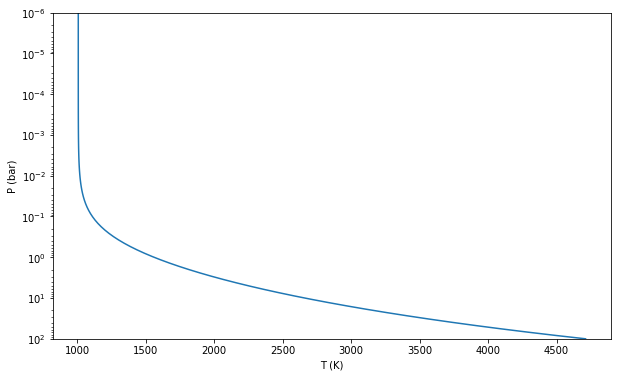

<Figure size 720x432 with 0 Axes>

In [3]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

We will also compare to the cloud-free case, and the case neglecting scattering again. For the last case we have to initialize a pRT object with ``do_scat_emis = False``, or omit the ``do_scat_emis`` keyword altogether when initializing the pRT object.

In [4]:
atmosphere_no_scat = Radtrans(line_species = ['H2O', 'CO_all_iso', 'CH4', 'CO2', 'Na', 'K'], \
      cloud_species = ['Mg2SiO4(c)_cd'], \
      rayleigh_species = ['H2', 'He'], \
      continuum_opacities = ['H2-H2', 'H2-He'], \
      wlen_bords_micron = [0.3, 15], \
      do_scat_emis = False)
pressures = np.logspace(-6, 2, 100)
atmosphere_no_scat.setup_opa_structure(pressures)


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Now we will plot the spectra for the three cases, including scattering, neglecting scattering, and turning off the clouds. In addition, we set ``contribution = True`` in the ``calc_flux()`` methods, such that we can study the contribution functions of the cases below. See ["Analysis Tools"](analysis.html) for more information on emission contribution functions.

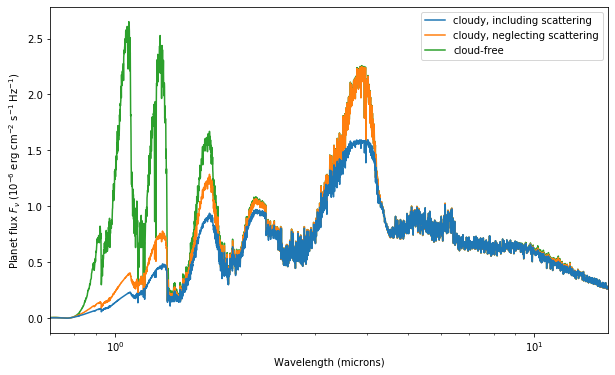

<Figure size 720x432 with 0 Axes>

In [5]:
import pylab as plt
mass_fractions['Mg2SiO4(c)'] = mfr_cloud

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       contribution = True)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloudy, including scattering', zorder = 2)
contribution_scat = atmosphere.contr_em

atmosphere_no_scat.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       contribution = True)
plt.plot(nc.c/atmosphere_no_scat.freq/1e-4, atmosphere_no_scat.flux/1e-6, \
         label = 'cloudy, neglecting scattering', zorder = 1)
contribution_no_scat = atmosphere_no_scat.contr_em

mass_fractions['Mg2SiO4(c)'] = 0.0 * np.ones_like(temperature)

atmosphere_no_scat.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm,
                       contribution = True)

plt.plot(nc.c/atmosphere_no_scat.freq/1e-4, atmosphere_no_scat.flux/1e-6, \
         label = 'cloud-free', zorder = 0)
contribution_clear = atmosphere_no_scat.contr_em

plt.legend(loc='best')
plt.xlim([0.7, 15])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()

Finally, we compare the emission contribution of the cloudy (with scattering) and clear case below. The cloud deck at 3 bar is clearly visible in the contribution function for the cloudy case, cutting off the emission from the atmosphere between 2 and 3 bar.

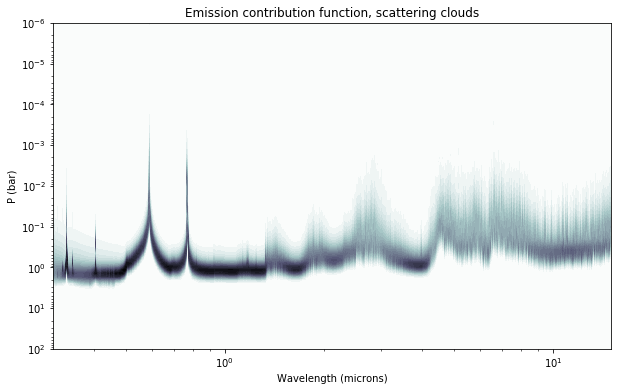

<Figure size 720x432 with 0 Axes>

In [6]:
wlen_mu = nc.c/atmosphere.freq/1e-4
X, Y = np.meshgrid(wlen_mu, pressures)
plt.contourf(X,Y,contribution_scat,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, scattering clouds')
plt.show()
plt.clf()

In contrast, no cloud hides the deep hot regions from view in the clear case, allowing for pressures of multiple 10s of bars being probed in the optical.

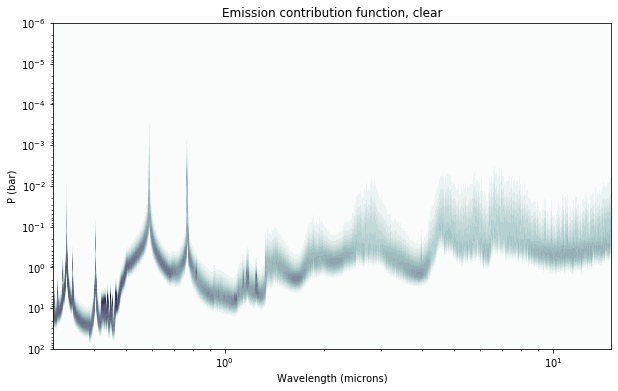

<Figure size 720x432 with 0 Axes>

In [7]:
plt.contourf(X,Y,contribution_clear,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, clear')
plt.show()
plt.clf()